In [77]:
import requests
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv
load_dotenv()

import os

In [78]:
TRAFIKVERKET_API=os.getenv("TRAFIKVERKET_KEY")
TRAFIKVERKET_URL="https://api.trafikinfo.trafikverket.se/v2/data.json"

In [79]:
question = f"""<REQUEST>
  <LOGIN authenticationkey="{TRAFIKVERKET_API}"/>
  <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">
    <FILTER>
      <EQ name="AdvertisedTrainIdent" value="936" />
      <GT name="AdvertisedTimeAtLocation" value="2024-04-19T00:00:00.000+02:00" />
      <LT name="AdvertisedTimeAtLocation" value="2024-04-20T00:00:00.000+02:00" />
    </FILTER>
  </QUERY>
</REQUEST>"""

question

'<REQUEST>\n  <LOGIN authenticationkey="e4f6b2548ecc4400b9fc59c4a4710fe8"/>\n  <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">\n    <FILTER>\n      <EQ name="AdvertisedTrainIdent" value="936" />\n      <GT name="AdvertisedTimeAtLocation" value="2024-04-19T00:00:00.000+02:00" />\n      <LT name="AdvertisedTimeAtLocation" value="2024-04-20T00:00:00.000+02:00" />\n    </FILTER>\n  </QUERY>\n</REQUEST>'

In [80]:
trainstation_question = f"""<REQUEST>
  <LOGIN authenticationkey="{TRAFIKVERKET_API}"/>
  <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">
    <FILTER>
      <EQ name="LocationSignature" value="Cst" />
      <GT name="AdvertisedTimeAtLocation" value="$dateadd(-1)" />
      <LT name="AdvertisedTimeAtLocation" value="$now" />
    </FILTER>
  </QUERY>
</REQUEST>"""

trainstation_question

'<REQUEST>\n  <LOGIN authenticationkey="e4f6b2548ecc4400b9fc59c4a4710fe8"/>\n  <QUERY objecttype="TrainAnnouncement" schemaversion="1.9" limit="1000">\n    <FILTER>\n      <EQ name="LocationSignature" value="Cst" />\n      <GT name="AdvertisedTimeAtLocation" value="$dateadd(-1)" />\n      <LT name="AdvertisedTimeAtLocation" value="$now" />\n    </FILTER>\n  </QUERY>\n</REQUEST>'

In [81]:
headers = {
  "Content-Type": "text/xml"
}
resp = requests.post(TRAFIKVERKET_URL, data=trainstation_question, headers=headers)
# resp = requests.post(TRAFIKVERKET_URL, data=trainstation_question)

resp

<Response [200]>

In [94]:
traininfo = resp.json()

traininfo

{'RESULT': [{'TrainAnnouncement': [{'ActivityId': '1500adde-f75d-c409-08dc-543920a4bde2',
     'ActivityType': 'Ankomst',
     'Advertised': False,
     'AdvertisedTimeAtLocation': '2024-04-19T14:25:00.000+02:00',
     'AdvertisedTrainIdent': '7839',
     'Canceled': False,
     'Deleted': False,
     'DepartureDateOTN': '2024-04-19T00:00:00.000+02:00',
     'EstimatedTimeIsPreliminary': False,
     'FromLocation': [{'LocationName': 'Arnn', 'Priority': 1, 'Order': 0}],
     'InformationOwner': 'A-train',
     'LocationDateTimeOTN': '2024-04-19T14:25:00.000+02:00',
     'LocationSignature': 'Cst',
     'ModifiedTime': '2024-04-19T12:26:24.976Z',
     'NewEquipment': 0,
     'Operator': 'ATRAIN',
     'OperationalTrainNumber': '7839',
     'OperationalTransportIdentifiers': [{'ObjectType': 'PR',
       'Company': '0074',
       'Core': '------LTP102',
       'Variant': '00',
       'TimetableYear': 2024,
       'StartDate': '2024-04-19'},
      {'ObjectType': 'TR',
       'Company': '302

In [83]:
len (traininfo['RESPONSE']['RESULT'][0]['TrainAnnouncement'])

773

In [84]:
df = pd.DataFrame(traininfo["RESPONSE"]["RESULT"][0]["TrainAnnouncement"])

df.head(1)
df.shape

(773, 38)

In [85]:
df = df[['AdvertisedTimeAtLocation', 'TimeAtLocation']]

df['AdvertisedTimeAtLocation'] = pd.to_datetime(df['AdvertisedTimeAtLocation'])
df['TimeAtLocation'] = pd.to_datetime(df['TimeAtLocation'])

df.loc[:, 'Delay'] = (df['TimeAtLocation'] - df['AdvertisedTimeAtLocation']).dt.total_seconds() / 60

df.mean()

AdvertisedTimeAtLocation    2024-04-19 02:09:15.912030976+02:00
TimeAtLocation              2024-04-19 02:20:02.410081536+02:00
Delay                                                   2.59757
dtype: object

<Axes: xlabel='AdvertisedTimeAtLocation'>

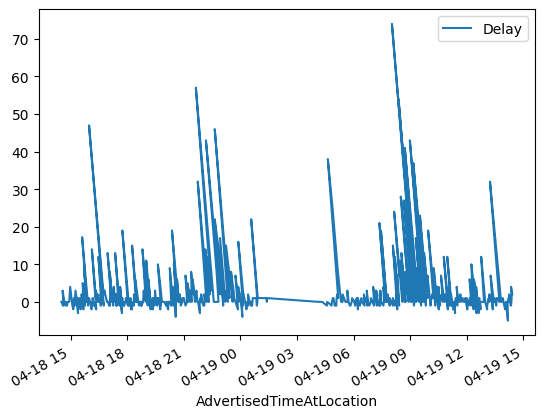

In [86]:
df.plot(x='AdvertisedTimeAtLocation', y='Delay')

<Axes: xlabel='AdvertisedTimeAtLocation', ylabel='Delay'>

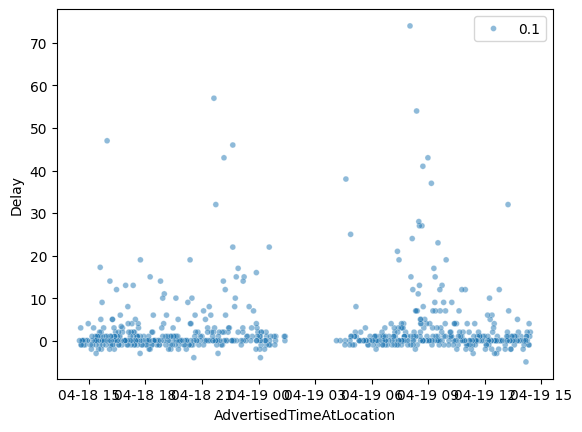

In [92]:
sns.scatterplot(data=df, x='AdvertisedTimeAtLocation', y='Delay', alpha=0.5, size=0.1)

<Axes: xlabel='Delay', ylabel='Count'>

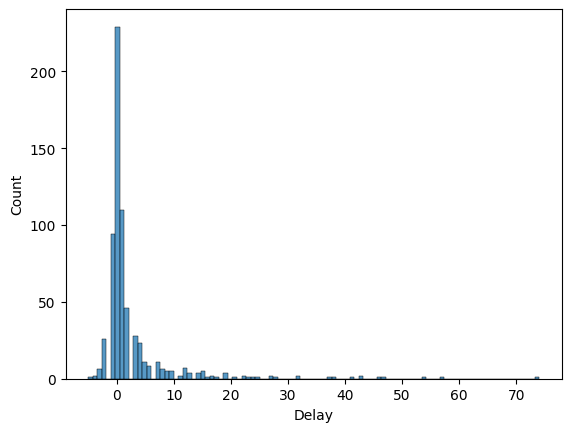

In [88]:
sns.histplot(df, x='Delay', bins=100)